In [1]:
from tqdm import tqdm
import pandas as pd
import torchaudio
import librosa
import shutil
import json
import os

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path = "../prep_data/raw_jsonl/train-data-type-12-v1.jsonl"
with open(path, "r", encoding="utf-8") as f:
    content = f.readlines()
    lines = [json.loads(line.strip()) for line in content]
    data = pd.DataFrame(lines)
print(data.shape)
data.head(2)

(161804, 13)


,id,raw,text,utt_id,start_time,end_time,arpas,trans,phone_scores,word_scores,decisions,word_ids,utterance_scores
0,4883249,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[91, 0, 99, 100, 98, 97, 97]",[84],"[2, 0, 2, 2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0]",84.0
1,2370306,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[90, 19, 97, 100, 96, 98, 87]",[84],"[2, 0, 2, 2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0]",84.0


In [3]:
def get_rank(phone_scores, phone_threshold=80):
    count, total = 0, 0
    for score in phone_scores:
        if score < phone_threshold:
            count += 1
        total += 1

    return count/total

rank = data.phone_scores.apply(get_rank)

<Axes: >

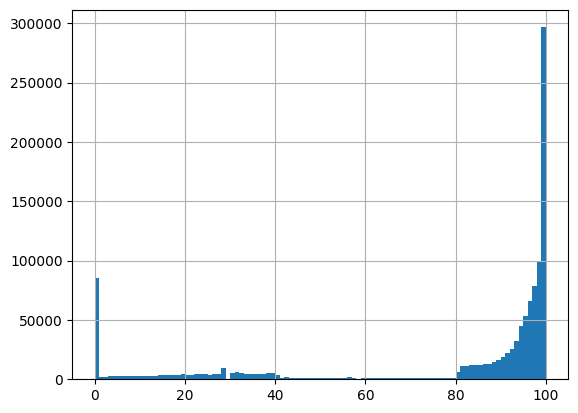

In [4]:
scores = data.apply(lambda x: x["phone_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

In [5]:
filtered_data = []
for name, group in data.groupby("text"):
    if group.shape[0] >= 300:
        # samples = rank[group.index].sort_values(ascending=False)
        # samples = group.loc[samples.index[0:100]]
        # filtered_data.append(samples)

        samples = group.sample(300)
        filtered_data.append(samples)

        # samples = rank[group.index].sort_values(ascending=False)
        # samples = samples[samples.index[0:100]].sample(50)
        # samples = group.loc[samples.index].reset_index()
        # filtered_data.append(samples)
        
        # filtered_data.append(group[100:].sample(200).reset_index())
    else:
        filtered_data.append(group)

filtered_data = pd.concat(filtered_data)
filtered_data.shape

(158053, 13)

<Axes: >

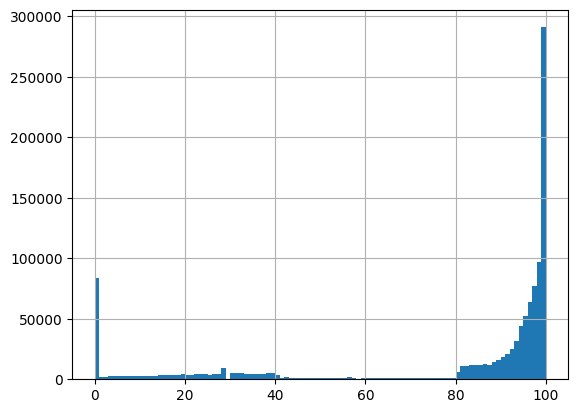

In [6]:
scores = filtered_data.apply(lambda x: x["phone_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

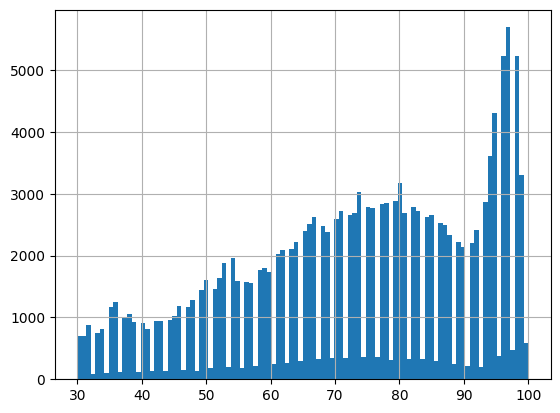

In [7]:
filtered_data.utterance_scores.hist(bins=100)

<Axes: >

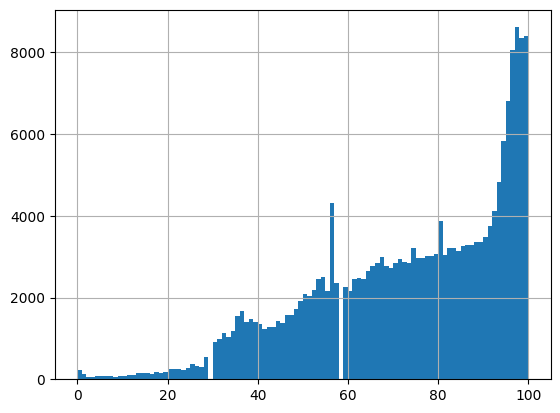

In [8]:
scores = filtered_data.apply(lambda x: x["word_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

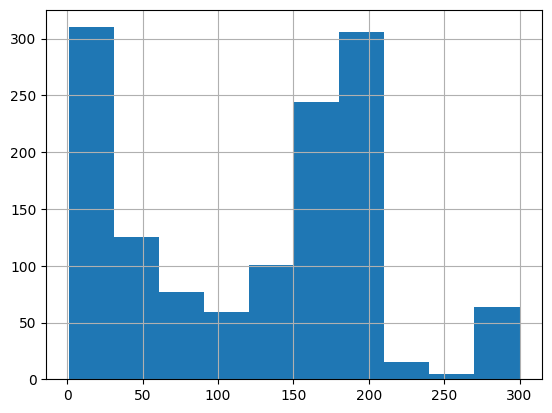

In [9]:
filtered_data.text.value_counts().hist()

In [10]:
from tqdm import tqdm
 
path = "../prep_data/raw_jsonl/train-data-type-12-v1.jsonl"
with open(path, "w", encoding="utf-8") as f:
    for index in tqdm(filtered_data.index):
        sample = filtered_data.loc[index].to_dict()
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

100%|██████████| 158053/158053 [00:05<00:00, 30006.07it/s]
